### ASSIST tests: Apophis

Here we use ASSIST to carry out an integration of the orbit of the interstellar object Oumuamua and compare the resluts with those of the JPL Horizons system. 

We include the non-gravitational forces as reported.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import ctypes
import importlib

import spiceypy as spice

import pkg_resources
import sys
sys.path.append(r'/Users/mholman/assist')
import assist

jd_ref = spice.j2000()

plt.rc('text', usetex = True)


In [3]:
# Here are setting up the integration of Apophis from 2029 Jan 1 to 2030 Jan 1.  There is a very
# close encounter between the asteroid and the Earth on 2029 April 13.  This is a significant
# stress test for the integrator, one that we fail!

# Davide's email: Apophis heliocentric state (km, km/sec)
apophis_davide = np.array([-8.1542363951087192E+07, 1.2904139592677031E+08, 4.5894255749981791E+07,
                           -2.4167584904236399E+01, -1.0027783141840974E+01, -4.3343221001451306E+00])

# Convert to AU and AU/day
au = 1.495978707e+08
day = 24*3600.

apophis_davide[0:3] = apophis_davide[0:3]/au
apophis_davide[3:6] = apophis_davide[3:6]*day/au

# Convert to barycentric

GMsun, sun = assist.all_ephem(0, jd_ref, 2462137.5-jd_ref)
apophis_davide = apophis_davide + sun[0:6]

davide_end = np.array([3.6363608866809485E+06, 1.8237263291973537E+08, 7.1543155513210312E+07,
                       -2.3434769151826927E+01, 1.0706266853019808E+00, 2.9804565046315526E-02])
#davide_end = davide_end/au

davide_quad = np.array([3.6363612965853503E+06, 1.8237263299836367E+08, 7.1543155513458297E+07])
davide_end[0:3] = davide_end[0:3]/au
davide_end[3:6] = davide_end[3:6]*day/au

# Convert to barycentric

GMsun, sun = assist.all_ephem(0, jd_ref, 2462502.5-jd_ref)
davide_end = davide_end + sun[0:6]


In [5]:
apophis_davide = np.array([-4.0985308396619768E-01, 9.0701988670897504E-01, 3.2679194720961291E-01, -1.5075524121278910E-02, -3.7135599257017366E-03, -1.7618679887745228E-03])
GMsun, sun = assist.all_ephem(0, jd_ref, 2459215.5-jd_ref)
apophis_davide = apophis_davide + sun[0:6]

In [19]:
(2462502.5-2462137.5)

365.0

In [4]:
# For these integrations, we have turned off solar J2 and Earth J3 and J4.  We keep full
# EIH GR and all perturbers.  Initially the perturbers are in ephemeris order.
tstart, tstep, trange = 2459215.5-jd_ref, 20.0, 0.0

tstart, tstep, trange = 2462137.5-jd_ref, 20.0, (2462502.5-2462137.5)

epoch = tstart
tend = tstart + trange

delta = 0e-16
instates = apophis_davide.copy()
instates[2] += delta

#n_var = 6
n_var = 0
#n_particles = 7
n_particles = 1
geocentric = 0

#invar_part = np.zeros(6, dtype=int)
invar_part = None
#invar = np.identity(6)
invar = None

scale = 1e-8
#instatesp = np.array([row]*6)+scale*invar
#instates=np.vstack([instates, instatesp])

# Turn off the non-grav terms
part_params = None
part_params = np.array([4.999999873689E-13, -2.901085508711E-14, 0.])
part_params = np.array([5.E-13, -2.901085583204654E-14, 0.0])

var_part_params = None

nsubsteps = 10
hg = np.arange(0, 1.1, 0.1, dtype=np.double)

times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                nsubsteps=nsubsteps, 
                                                                epsilon=1e-8, min_dt=0.0001)

In [5]:
(states[-1][0]-davide_end)*1.5e8

array([-1643.73412973,  -295.3433222 ,  -176.35851448,    -3.22039455,
         -16.33853032,    -6.6243652 ])

In [9]:
jpl_apophis_start = np.array([-5.438438272487275E-01, 8.613083849766898E-01, 3.062632838449565E-01,
                                  -1.395835707852086E-02, -5.786710318140503E-03, -2.501201213363947E-03])
jpl_apophis_end = np.array([2.487313278602400E-02,  1.219360347406856E+00, 4.784027483997944E-01,
         -1.353775762820969E-02, 6.220289094212166E-04, 1.888305072804014E-05])

# For these integrations, we have turned off solar J2 and Earth J3 and J4.  We keep full
# EIH GR and all perturbers.  Initially the perturbers are in ephemeris order.
tstart, tstep, trange = 2462137.500000000-jd_ref, 20.0, (2462502.5-2462137.5)

epoch = tstart
tend = tstart + trange

delta = 0e-16
instates = jpl_apophis_start.copy()
instates[0] += delta

#n_var = 6
n_var = 0
#n_particles = 7
n_particles = 1
geocentric = 0

#invar_part = np.zeros(6, dtype=int)
invar_part = None
#invar = np.identity(6)
invar = None

scale = 1e-8
#instatesp = np.array([row]*6)+scale*invar
#instates=np.vstack([instates, instatesp])

#  AMRAT=  0.                                                                  
#  A1= 4.999999873689E-13  A2= -2.901085508711E-14 A3= 0.                      
# Non-standard or simulated/proxy model:                                        
#   ALN=  1.            NK=  0.       NM=  2.       NN=  5.093    R0=  1.      

# Turn off the non-grav terms
part_params = None
#part_params = np.array([4.999999873689E-13, -2.901085508711E-14, 0.])
A1, A2, A3 = 4.999999873689E-13, -2.901085508711E-14, 0.0
#A1, A2, A3 = 0.0, -5.592839897872E-14, 0.0
part_params = np.array([A1, A2, A3])

var_part_params = None

nsubsteps = 10
hg = np.arange(0, 1.1, 0.1, dtype=np.double)

times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                nsubsteps=nsubsteps, 
                                                                epsilon=1e-8, min_dt=0.01)

#(states[-1][0]-prev)[0:3]*1.5e11
(states[-1][0]-jpl_apophis_end)[0:3]*1.5e8


array([-3529.51754393,  -576.72121722, -1077.80881969])

In [10]:
earth_pos=[]
for t in times:
    GMearth, earth = assist.all_ephem(3, jd_ref, t)
    earth_pos.append(earth)

earth_pos = np.array(earth_pos)

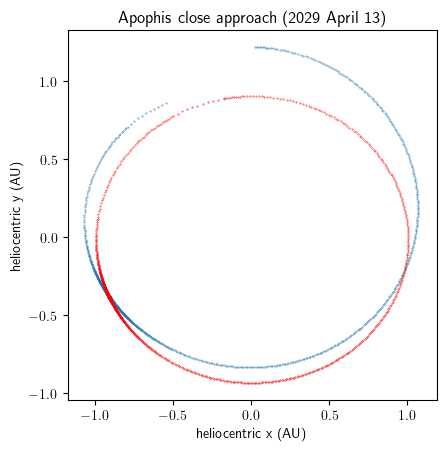

In [11]:
plt.scatter(states[:,0,0], states[:,0,1], s=0.1)
plt.scatter(earth_pos[:,0], earth_pos[:,1], s=0.1, c='red')
#plt.xlim(-1.2, -0.5)
#plt.ylim(-0.6, -0.2)
plt.axis('square')
plt.title('Apophis close approach (2029 April 13)')
plt.xlabel('heliocentric x (AU)')
plt.ylabel('heliocentric y (AU)')
plt.savefig('apophis_earth.pdf')

In [17]:
# This routine is integrating a pair of trajectories, one of Apophis and another of a slightly
# perturbed (in the x coordinate) Apophis, for a time t from 2029 Jan 1.  The magnitude of the
# difference of the positions of the two trajectories at the end of the integration is 
# returned.  The point is to be able to study the difference as the trajectories approach
# and pass through close encounters with the Earth.

def perturbed_apophis(t):
    # For these integrations, we have turned off solar J2 and Earth J3 and J4.  We keep full
    # EIH GR and all perturbers.  Initially the perturbers are in ephemeris order.

    tstart, tstep, trange = 2462137.500000000-jd_ref, 20.0, t

    epoch = tstart
    tend = tstart + trange

    delta = 0e-16
    instates = jpl_apophis_start.copy()
    instates[0] += delta

    n_var = 0
    n_particles = 1
    geocentric = 0

    invar_part = None
    invar = None

    scale = 1e-8

    # Turn off the non-grav terms
    part_params = None

    var_part_params = None

    nsubsteps = 10
    hg = np.arange(0, 1.1, 0.1, dtype=np.double)

    times, states, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                    n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                    nsubsteps=nsubsteps, 
                                                                    epsilon=1e-9, min_dt=0.001)
    
    delta = 1e-15
    instates = jpl_apophis_start.copy()
    instates[0] += delta

    n_var = 0
    n_particles = 1
    geocentric = 0

    invar_part = None
    invar = None

    scale = 1e-8

    # Turn off the non-grav terms
    part_params = None

    var_part_params = None

    nsubsteps = 10
    hg = np.arange(0, 1.1, 0.1, dtype=np.double)

    times2, states2, var, var_ng, status = assist.integration_function(tstart, tend, tstep, geocentric, 
                                                                    n_particles, instates, part_params, n_var, invar_part, invar, var_part_params, hg,
                                                                    nsubsteps=nsubsteps, 
                                                                    epsilon=1e-9, min_dt=0.001)

    return np.linalg.norm((states2[-1][0]-states[-1][0])[0:3])*1.5e11


In [18]:
# Compute the divergence of the trajectories for a range of times.
ts = []
dxs = []
for t in np.arange(1, 110, 1.):
    print(t)
    ts.append(t)
    dxs.append(perturbed_apophis(t))

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0
101.0
102.0
103.0
104.0
105.0
106.0
107.0
108.0
109.0


In [14]:
plt.rcParams['figure.figsize'] = (6, 6)

In [19]:
ts = np.array(ts)
dxs = np.array(dxs)

Text(0, 0.5, 'divergence (m)')

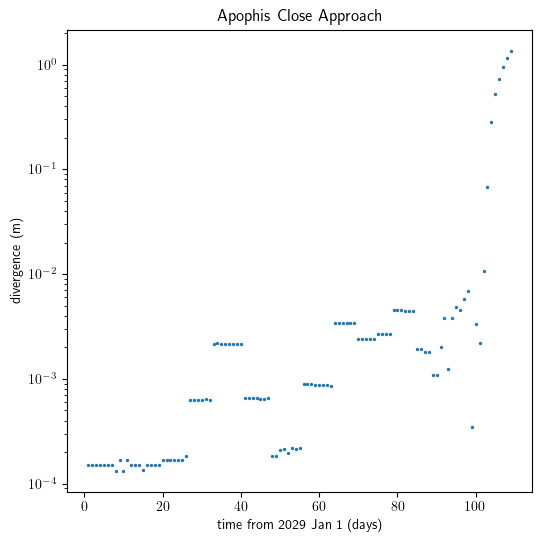

In [20]:
plt.scatter(ts, dxs, s=2)
plt.yscale('log')
plt.title('Apophis Close Approach')
plt.xlabel('time from 2029 Jan 1 (days)')
plt.ylabel('divergence (m)')
#plt.savefig('apophis_divergence.pdf')

(0.0, 110.0)

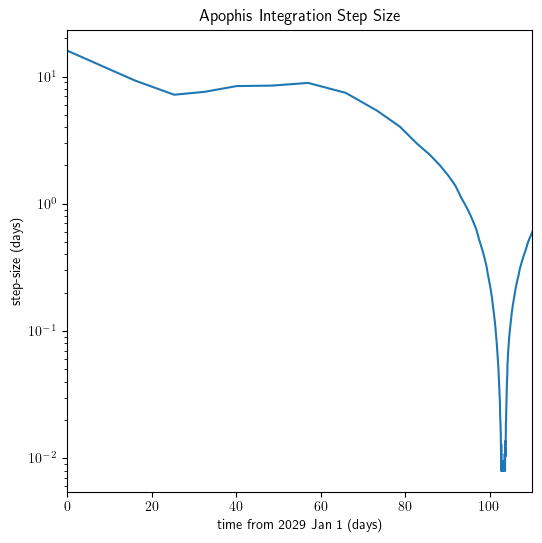

In [24]:
# This figure shows two close approaches.  The
# first is near day 30.  The second, deeper encounter
# is near day 100.

t=(times-times[0])[::8]
dt=t[1:]-t[:-1]

plt.plot(t[:-1], dt)
plt.title('Apophis Integration Step Size')
plt.xlabel("time from 2029 Jan 1 (days)")
plt.ylabel("step-size (days)")
plt.yscale('log')
plt.xlim(0,110)
#plt.savefig('apophis_step_size.pdf')
#plt.xlim(0,110)